# **Zillow House Prices ZHVI and ZORI Modeling & Forecasting**

## **ZHVI : Zillow Home Value Index**

### **Data and Dependencies Load**

In [1]:
# Dependencies Load

import pandas as pd
import numpy as np
import pickle

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 100
pd.options.display.max_columns = None

In [2]:
# Data Load

zhvi = pd.read_pickle('../data/zhvi.pkl')

In [3]:
# Data head

zhvi.head()

,Region,State,Date,ZHVI,Type
1,"New York, NY",NY,2000-01-31,190767.90,Condo
2,"Los Angeles, CA",CA,2000-01-31,177240.45,Condo
3,"Chicago, IL",IL,2000-01-31,126942.50,Condo
4,"Dallas, TX",TX,2000-01-31,88627.72,Condo
5,"Houston, TX",TX,2000-01-31,83915.41,Condo


### **Data Preparation**

In [4]:
# Remove suffix in the 'Region' column
def remove_region_suffix(df):
    df['Region'] = df['Region'].str.split(',').str[0]
    return df

zhvi = remove_region_suffix(zhvi)

In [5]:
# 'State' is same as region so dropping it
zhvi.drop(columns='State', inplace=True)

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Narrow down the dataset to have records after Dec 2020 due to COVID
zhvi = zhvi[zhvi['Date'] > '2020-12-31']

# Set date as index
zhvi = zhvi.set_index('Date')

# Extract date features
zhvi['Year'] = zhvi.index.year
zhvi['Month'] = zhvi.index.month
zhvi['Week'] = zhvi.index.isocalendar().week
zhvi['Day'] = zhvi.index.day

# One-hot encode categorical features
categorical_cols = ['Region', 'Type']
numerical_cols = ['ZHVI']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
pipeline_zhvi = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical_cols)], remainder='passthrough')

X = pipeline_zhvi.fit_transform(zhvi[categorical_cols + ['Year', 'Month', 'Week', 'Day']])
y = zhvi['ZHVI']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Modeling**

In [7]:
# Gradient Boosting Regression
gb_zhvi = GradientBoostingRegressor(random_state=42)
gb_zhvi.fit(X_train, y_train)
gb_zhvi_forecast = gb_zhvi.predict(X_test)
gb_zhvi_mse = mean_squared_error(y_test, gb_zhvi_forecast)
gb_zhvi_r2 = r2_score(y_test, gb_zhvi_forecast)

print(f'\nGradient Boosting ZHVI Regression MSE: {gb_zhvi_mse:.2f}, R^2: {gb_zhvi_r2:.2f}\n')


Gradient Boosting ZHVI Regression MSE: 12164502046.84, R^2: 0.51



In [8]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# XGBoost Regression
xgb_zhvi = XGBRegressor(random_state=42)
xgb_zhvi.fit(X_train, y_train)
xgb_zhvi_forecast = xgb_zhvi.predict(X_test)
xgb_zhvi_mse = mean_squared_error(y_test, xgb_zhvi_forecast)
xgb_zhvi_r2 = r2_score(y_test, xgb_zhvi_forecast)

print(f'\nXGBoost ZHVI Regression MSE: {xgb_zhvi_mse:.2f}, R^2: {xgb_zhvi_r2:.2f}\n')


XGBoost ZHVI Regression MSE: 5135223218.67, R^2: 0.79



In [9]:
# LightGBM Regression
lgbm_zhvi = LGBMRegressor(random_state=42)
lgbm_zhvi.fit(X_train, y_train)
lgbm_zhvi_forecast = lgbm_zhvi.predict(X_test)
lgbm_zhvi_mse = mean_squared_error(y_test, lgbm_zhvi_forecast)
lgbm_zhvi_r2 = r2_score(y_test, lgbm_zhvi_forecast)

print(f'\nLightGBM ZHIV Regression MSE: {lgbm_zhvi_mse:.2f}, R^2: {lgbm_zhvi_r2:.2f}\n')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1656
[LightGBM] [Info] Number of data points in the train set: 118418, number of used features: 812
[LightGBM] [Info] Start training from score 229817.195500

LightGBM ZHIV Regression MSE: 4817218012.87, R^2: 0.81



In [10]:
from prophet import Prophet

# Prepare data for Prophet
zhvi_prophet = zhvi.reset_index()[['Date', 'ZHVI']]
zhvi_prophet.columns = ['ds', 'y']

# Fit Prophet model
prophet_zhvi = Prophet()
prophet_zhvi.fit(zhvi_prophet)

# Make future predictions
future_zhvi = prophet_zhvi.make_future_dataframe(periods=365)  # Forecast for the next year
forecast_zhvi = prophet_zhvi.predict(future_zhvi)

forecast_zhvi_df = pd.DataFrame(forecast_zhvi)

forecast_zhvi_df[['ds', 'trend', 'yhat_lower', 'yhat_upper', 'yhat']].head()

19:00:43 - cmdstanpy - INFO - Chain [1] start processing
19:00:50 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,yhat
0,2021-01-31,198654.096157,-9640.779435,377095.330533,192581.376694
1,2021-02-28,195942.659834,9383.917841,402336.316191,193101.250104
2,2021-03-31,196335.002616,-5642.151014,403658.971857,194287.595679
3,2021-04-30,198513.901033,-183.334795,404306.977537,198262.338024
4,2021-05-31,201571.379523,637.833734,396417.479905,201467.669317


<Figure size 1500x800 with 0 Axes>

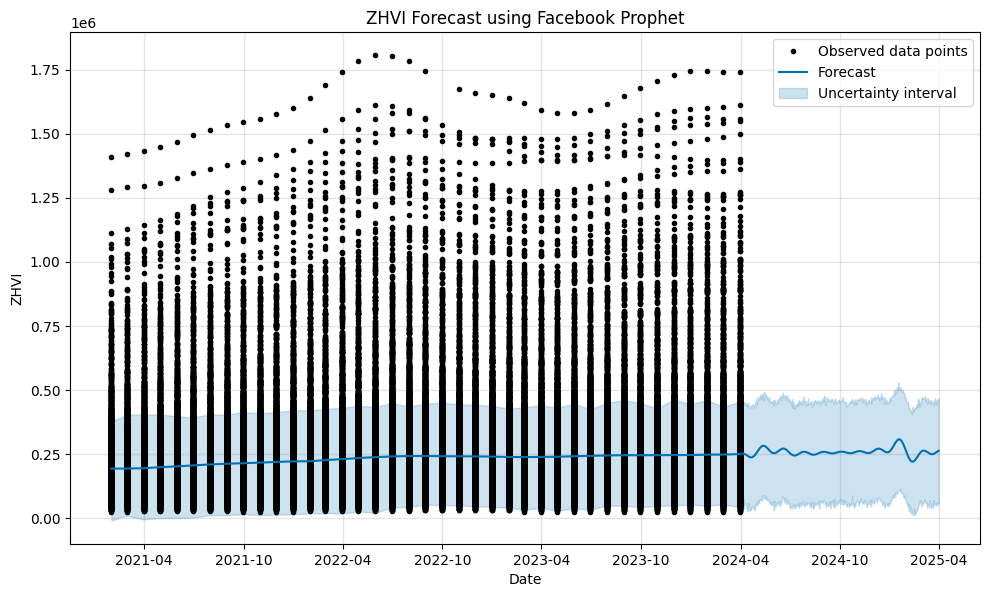

In [11]:
# Visualize forecasts
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
prophet_zhvi.plot(forecast_zhvi, xlabel='Date', ylabel='ZHVI')
plt.title('ZHVI Forecast using Facebook Prophet')
plt.legend()
plt.show()

In [12]:
# Export models
with open('../models/xgb_zhvi.pkl', 'wb') as file:
    pickle.dump(xgb_zhvi, file)

with open('../models/lgbm_zhvi.pkl', 'wb') as file:
    pickle.dump(lgbm_zhvi, file)

## **ZORI : Zillow Observed Rent Index**

### **Data Preparation**

In [13]:
# Data Load

zori = pd.read_pickle('../data/zori.pkl')

In [14]:
# Data head

zori.head()

,Region,State,Date,ZORI,Type
1,"New York, NY",NY,2015-01-31,2440.70,Single Family
2,"Los Angeles, CA",CA,2015-01-31,2577.07,Single Family
3,"Chicago, IL",IL,2015-01-31,1527.58,Single Family
4,"Dallas, TX",TX,2015-01-31,1372.17,Single Family
5,"Houston, TX",TX,2015-01-31,1496.71,Single Family


In [15]:
# Remove 'Region' suffix
zori = remove_region_suffix(zori)

In [16]:
# 'State' is same as region so dropping it
zori.drop(columns='State', inplace=True)

In [17]:
# Data head
zori.head()

,Region,Date,ZORI,Type
1,New York,2015-01-31,2440.70,Single Family
2,Los Angeles,2015-01-31,2577.07,Single Family
3,Chicago,2015-01-31,1527.58,Single Family
4,Dallas,2015-01-31,1372.17,Single Family
5,Houston,2015-01-31,1496.71,Single Family


In [18]:
# Narrow down the dataset to have records after Dec 2020 due to COVID
zori = zori[zori['Date'] > '2020-12-31']

# Set date as index
zori = zori.set_index('Date')

# Extract date features
zori['Year'] = zori.index.year
zori['Month'] = zori.index.month
zori['Week'] = zori.index.isocalendar().week
zori['Day'] = zori.index.day

# One-hot encode categorical features
categorical_cols = ['Region', 'Type']
numerical_cols = ['ZORI']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
pipeline_zori = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical_cols)], remainder='passthrough')

X = pipeline_zori.fit_transform(zori[categorical_cols + ['Year', 'Month', 'Week', 'Day']])
y = zori['ZORI']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Modeling**

In [19]:
# Gradient Boosting Regression
gb_zori = GradientBoostingRegressor(random_state=42)
gb_zori.fit(X_train, y_train)
gb_zori_forecast = gb_zori.predict(X_test)
gb_zori_mse = mean_squared_error(y_test, gb_zori_forecast)
gb_zori_r2 = r2_score(y_test, gb_zori_forecast)

print(f'\nGradient Boosting ZORI Regression MSE: {gb_zori_mse:.2f}, R^2: {gb_zori_r2:.2f}\n')


Gradient Boosting ZORI Regression MSE: 200373.48, R^2: 0.71



In [20]:
# XGBoost Regression
xgb_zori = XGBRegressor(random_state=42)
xgb_zori.fit(X_train, y_train)
xgb_zori_forecast = xgb_zori.predict(X_test)
xgb_zori_mse = mean_squared_error(y_test, xgb_zori_forecast)
xgb_zori_r2 = r2_score(y_test, xgb_zori_forecast)

print(f'\nXGBoost ZORI Regression MSE: {xgb_zhvi_mse:.2f}, R^2: {xgb_zori_r2:.2f}\n')


XGBoost ZORI Regression MSE: 5135223218.67, R^2: 0.86



In [21]:
# LightGBM Regression
lgbm_zori = LGBMRegressor(random_state=42)
lgbm_zori.fit(X_train, y_train)
lgbm_zori_forecast = lgbm_zori.predict(X_test)
lgbm_zori_mse = mean_squared_error(y_test, lgbm_zori_forecast)
lgbm_zori_r2 = r2_score(y_test, lgbm_zori_forecast)

print(f'\nLightGBM ZORI Regression MSE: {lgbm_zhvi_mse:.2f}, R^2: {lgbm_zori_r2:.2f}\n')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 19593, number of used features: 332
[LightGBM] [Info] Start training from score 1578.992089

LightGBM ZORI Regression MSE: 4817218012.87, R^2: 0.61



In [22]:
# Prepare data for Prophet
zori_prophet = zori.reset_index()[['Date', 'ZORI']]
zori_prophet.columns = ['ds', 'y']

# Fit Prophet model
prophet_zori = Prophet(daily_seasonality=True)  # Enable daily seasonality
prophet_zori.fit(zori_prophet)

# Make future predictions
future_zori = prophet_zori.make_future_dataframe(periods=365, freq='D')  # Set frequency to daily
forecast_zori = prophet_zori.predict(future_zori)

# Convert forecast to DataFrame
forecast_zori_df = pd.DataFrame(forecast_zori)

# Display the first few rows of the forecast
forecast_zori_df[['ds', 'trend', 'yhat_lower', 'yhat_upper', 'yhat']].head()

19:00:54 - cmdstanpy - INFO - Chain [1] start processing
19:00:56 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,yhat
0,2021-01-31,2756.438769,266.647922,2468.702803,1412.663045
1,2021-02-28,2758.356805,299.844780,2487.742478,1399.723084
2,2021-03-31,2774.744394,278.966176,2463.414805,1406.055641
3,2021-04-30,2790.603350,334.981016,2535.144712,1432.573740
4,2021-05-31,2806.986854,283.529000,2585.336579,1443.956329


<Figure size 1500x800 with 0 Axes>

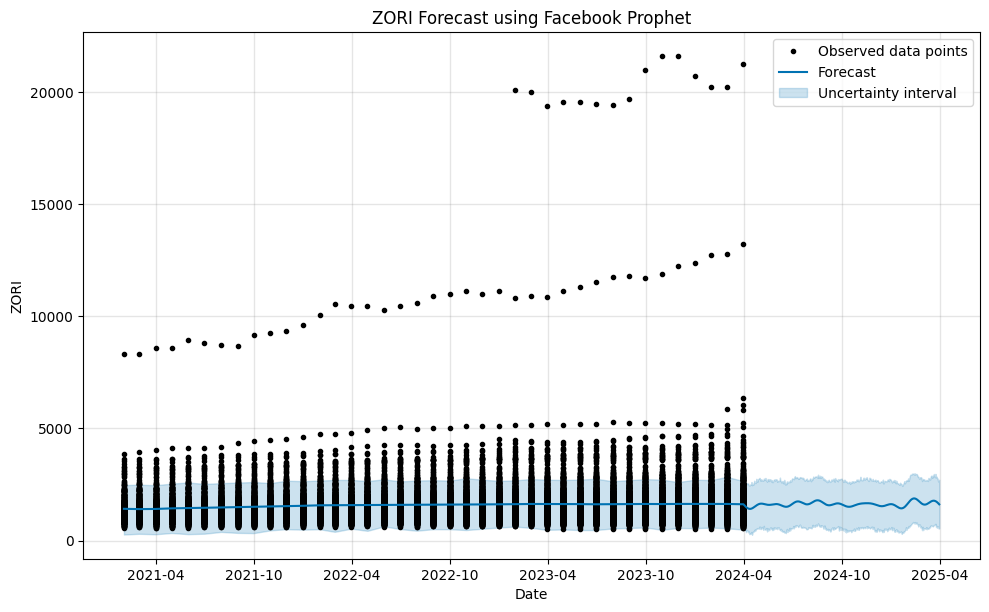

In [23]:
# Visualize forecasts

plt.figure(figsize=(15, 8))

prophet_zori.plot(forecast_zori, xlabel='Date', ylabel='ZORI')

plt.title('ZORI Forecast using Facebook Prophet')
plt.legend()
plt.show()

In [24]:
# Export models
with open('../models/xgb_zori.pkl', 'wb') as file:
    pickle.dump(xgb_zori, file)

with open('../models/lgbm_zori.pkl', 'wb') as file:
    pickle.dump(lgbm_zori, file)